In [1]:
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt
from astropy.io import ascii

  MJD            lum           ...       Mbolerr         t_exp 
------- ---------------------- ... -------------------- -------
 20.166 2.4592813475746336e+42 ... 0.009240913888790449  20.166
 21.175 2.4789594115318224e+42 ... 0.009539057912158418  21.175
 22.184 2.4810434522392757e+42 ... 0.009715092272037793  22.184
 23.193 2.4222966018867016e+42 ... 0.009318561596318971  23.193
 24.202 2.3693249519710398e+42 ... 0.009002470550907844  24.202
 25.211 2.3412433329279956e+42 ... 0.008965216059060737  25.211
  26.22 2.3111390496765778e+42 ... 0.008917472029441861   26.22
 27.228  2.278660518461376e+42 ... 0.008844617371217434  27.228
 28.237 2.2379615840100012e+42 ... 0.008599607896595057  28.237
 29.246 2.2184484500476905e+42 ... 0.008525725562543926  29.246
    ...                    ... ...                  ...     ...
105.922  4.470737467164991e+41 ... 0.026724508792007756 105.922
106.931  4.654854475311832e+41 ...  0.03261452455862232 106.931
 107.94  4.473824971230998e+41 ...  0.03

  2%|▏         | 81/5000 [00:02<03:00, 27.26it/s]C:\Users\jvasq\AppData\Local\Temp\ipykernel_11132\1246329981.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)
100%|██████████| 5000/5000 [02:23<00:00, 34.85it/s]


Best-fit parameters:
Param: 1.9484909541314401 + 0.29774084992444827 - 0.18829043804431644
Param: 91.1401298478948 + 1.5392623579873828 - 1.0863304769322752
Param: 9.415642965769102 + 1.6121053924457769 - 1.0911948605983959
Param: 0.001970232042885426 + 0.0015659039993389224 - 0.0021104439506845363
Param: -15.28943712846526 + 0.36224831854656614 - 0.23921842620126554
[1.9484909541314401, 91.1401298478948, 9.415642965769102, 0.001970232042885426, -15.28943712846526]
  MJD            lum           ...       Mbolerr         t_exp 
------- ---------------------- ... -------------------- -------
 20.166 2.4592813475746336e+42 ... 0.009240913888790449  20.166
 21.175 2.4789594115318224e+42 ... 0.009539057912158418  21.175
 22.184 2.4810434522392757e+42 ... 0.009715092272037793  22.184
 23.193 2.4222966018867016e+42 ... 0.009318561596318971  23.193
 24.202 2.3693249519710398e+42 ... 0.009002470550907844  24.202
 25.211 2.3412433329279956e+42 ... 0.008965216059060737  25.211
  26.22 2.31113904

<Figure size 640x480 with 0 Axes>

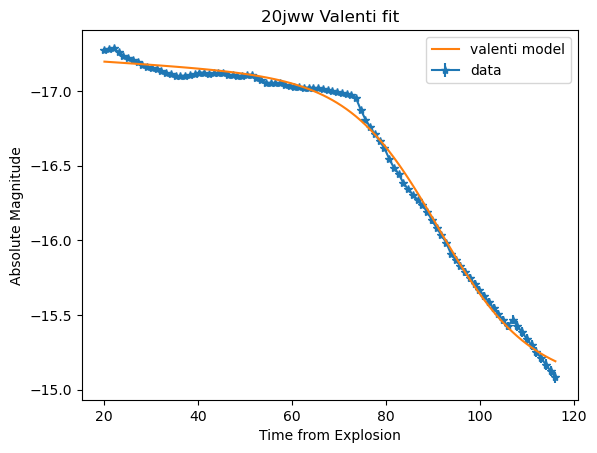

In [2]:
plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file='jww_bol_LC'
mjd_start=0

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=20):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    #print(table)
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    table['MJD'] = table['MJD']
    Mbol = -2.5*np.log10(table['lum']) + 83.9605452803 + 4.74
    Mbolerr = 1.086 * (table['dlum'] / table['lum'])

    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column(table['MJD'].data-mjd_start,name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
    print(table)
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [1.7391707763335567, 111.06179709805089, 7.203197652533321, 0.008194307783125725, -13.583601384015793]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    mask = np.abs(table['MJD'] - mjd_start) < 1
    table = table[~mask]
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)
   

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]
print(best_fit)
table = load_table(data_file)
plt.figure() 

plt.errorbar(table['MJD']-mjd_start, table['Mbol'], yerr=table['Mbolerr'], marker='*', zorder=5, label = 'data')

    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plt.plot(table['MJD']-mjd_start, model_lum, zorder=10, label = 'valenti model')

#plt.ylim([-14,-20])
plt.ylabel('Absolute Magnitude')
plt.xlabel('Time from Explosion')
plt.legend()
plt.title('20jww Valenti fit')
plt.gca().invert_yaxis()

plt.show()

In [3]:
luminosity=[]
# Using 105.0 rest-frame days as reference time
lightcurve_ref_time = 105-mjd_start
print(lightcurve_ref_time)
for s in samples:
    abs_mag=valenti_model(lightcurve_ref_time, s)
    luminosity.append(3.839e33 * 10**(-0.4 * (abs_mag-4.74)))

data = np.percentile(luminosity, [16, 50, 84])
lum=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Luminosity (1e39 erg/s)=','%1.2f'%(lum*1.0e-39),'+','%1.2f'%(errhi*1.0e-39),'-','%1.2f'%(errlo*1.0e-39))
print(data) 
print(errhi)
print(errlo)

# Heating rate for Co-56 decay in erg/s/g
epsilon = 6.8e9
# Mass of Co-56 in grams at 270 days
mass_Co56 = np.array(luminosity) / epsilon

# Radioactive decay timescale for Ni-56 and Co-56.  These are equal to ln(2)/(half-life)
# Half-life for Ni-56 is 6.075 days, Half-life for Co-56 is 55.93983 days
lambda_Co56 = np.log(2)/55.9383
lambda_Ni56 = np.log(2)/6.075

# Mass of Ni-56 at t=0
mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
data = np.percentile(mass_Ni56, [16, 50, 84])
print(data)
mass=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Mass (Msun)=','%1.4f'%(mass/(1.989e33)),'+','%1.4f'%(errhi/(1.989e33)),'-','%1.4f'%(errlo/(1.989e33)))

105
Luminosity (1e39 erg/s)= 456.53 + 11.96 - 10.09
[4.46443303e+41 4.56532187e+41 4.68495875e+41]
1.1963688252531767e+40
1.0088883580434431e+40
[2.14977476e+32 2.19835613e+32 2.25596532e+32]
Mass (Msun)= 0.1105 + 0.0029 - 0.0024


In [4]:
def erg(x):
    Lsun = 3.838e33 #erg/s
    L = Lsun * 10 ** (0.4 *(4.74 - x))
    return L 

In [5]:
def abs_mag(x):
   Mbol_sun = 4.74 
   log_L_sun = 83.9605452803 # - 2.5 * log10(3.838e33)
   Mbol = -2.5 * x['lum'] + log_L_sun + Mbol_sun
   return Mbol  

In [6]:
sn87a = table.read('1987A.dat', format = 'ascii', names = ('MJD', 'lum', 'dlum')) 
Mbol_87a = abs_mag(sn87a)

In [7]:
jww_interp = np.interp(105, table['MJD'], table['Mbol'])
jww_L = erg(jww_interp)
sn87a_interp = np.interp(105, sn87a['MJD'], Mbol_87a)
sn87a_L = erg(sn87a_interp)

In [8]:
Ni_87a = 0.075 
Ni_jww = Ni_87a * (jww_L / sn87a_L)
Ni_jww

0.11004266654130697

In [9]:
lum = table['lum']
dlum = table['dlum']
peakL = np.max(lum)
peakL_idx = np.argmax(lum)
peakL_err = (peakL - table['dlum'][peakL_idx]) / peakL 
print(f'Peak L = {peakL} +/- {peakL_err}')

Peak L = 2.4810434522392757e+42 +/- 0.9910542428434275
